# PIC-SURE R API use-case: Phenome-Wide analysis on BioData Catalyst studies

This notebook is an illustration example about how to query data using the R **PIC-SURE API**. It takes as use-case a simple PheWAS analysis. This notebook is intentionally straightforward, and explanation provided are only aimed at guiding through the PheWAS analysis process. For a more step-by-step introduction to the R PIC-SURE API, see the `1_PICSURE_API_101.ipynb` notebook.

**Before running this notebook, please be sure to get an user-specific security token. For more information on how to proceed, see the `get_your_token.ipynb` notebook**

## Environment set-up

### System requirements
- R 4.0 or later

### Packages installation

In [1]:
source("R_lib/requirements.R")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

also installing the dependency ‘gert’


Warning message in install.packages("usethis"):
“installation of package ‘gert’ had non-zero exit status”
Warning message in install.packages("usethis"):
“installation of package ‘usethis’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



installing: 
-  ggplot2 
-  dplyr 
-  tidyr 
-  urltools 
-  devtools 
-  ggrepel 


also installing the dependencies ‘systemfonts’, ‘textshaping’, ‘gert’, ‘ragg’, ‘usethis’, ‘pkgdown’


Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘systemfonts’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘gert’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘textshaping’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘usethis’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘ragg’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘devtools’ had non-zero exit status”
Warning message in install.packages(package, dependencies = TRUE):
“installation of package ‘pkgdown’ had non-zero exit status”

ERROR: Error in library(package, character.only = TRUE): there is no package called ‘devtools’


#### Installing latest R PIC-SURE API libraries from github

In [2]:
library('devtools', lib.loc = '~/studies/avillachlab-picsure-libraries-all/lib/')

Warning message in extract_lang(f = comp_lang, y = quote(if (.isMethodsDispatchOn() && :
“Devtools is incompatible with the current version of R. `load_all()` may function incorrectly.”


In [3]:
Sys.setenv(TAR = "/bin/tar")
options(unzip = "internal")
#install.packages("https://cran.r-project.org/src/contrib/Archive/devtools/devtools_1.13.6.tar.gz", repos=NULL, type="source")
install.packages("https://cran.r-project.org/src/contrib/R6_2.5.1.tar.gz", repos=NULL, type="source")
install.packages("https://cran.r-project.org/src/contrib/hash_2.2.6.1.tar.gz", repos=NULL, type="source")
install.packages(c("urltools"),repos = "http://cran.us.r-project.org")
devtools::install_github("hms-dbmi/pic-sure-r-client", force=T)
devtools::install_github("hms-dbmi/pic-sure-r-adapter-hpds", force=T)
devtools::install_github("hms-dbmi/pic-sure-biodatacatalyst-r-adapter-hpds", force=T)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

from URL https://api.github.com/repos/hms-dbmi/pic-sure-r-client/zipball/master

Installing picsure

'/home/ec2-user/anaconda3/envs/R/lib/R/bin/R' --no-site-file --no-environ  \
  --no-save --no-restore --quiet CMD INSTALL  \
  '/tmp/RtmpMeu5LQ/devtools7a37121022f7/hms-dbmi-pic-sure-r-client-115deb5'  \
  --library='/home/ec2-user/anaconda3/envs/R/lib/R/library' --install-tests 



from URL https://api.github.com/repos/hms-dbmi/pic-sure-r-adapter-hpds/zipball/master

Installing hpds

'/home/ec2-user/anaconda3/envs/R/lib/R/bin/R' --no-site-file --no-environ  \
  --no-save --no-restore --quiet CMD INSTALL  \
  '/tmp/RtmpMeu5LQ/devtools7a37446c63e1/hms-dbmi-pic-sure-r-adapter-hpds-2cee5ee'  \
  --library='/home/ec2-user/anaconda3/envs/R/lib/R/library' --install-tests 



from URL https://api.github.com/repos/hms-dbmi/pic-sure-biodatacatalyst-r-adapter-hpds/zipball/master

Installing bdc

from URL https://api.

In [4]:
########testing cell
library(dplyr)
library(ggplot2)

#### Loading user-defined functions

In [5]:
source("R_lib/utils.R")

## Connecting to a PIC-SURE network

In [6]:
PICSURE_network_URL <- "https://picsure.biodatacatalyst.nhlbi.nih.gov/picsure"
resource_id <- "02e23f52-f354-4e8b-992c-d37c8b9ba140"
token_file <- "token.txt"

In [7]:
token <- scan(token_file, what = "character")


In [8]:
myconnection <- picsure::connect(url = PICSURE_network_URL,
                                 token = token)

[1] "02e23f52-f354-4e8b-992c-d37c8b9ba140"
[2] "70c837be-5ffc-11eb-ae93-0242ac130002"


In [9]:
resource <- bdc::get.resource(myconnection,
                               resourceUUID = resource_id)

[1] "Loading data dictionary... (takes a minute)"


# PheWAS analysis
*Note: This example is not meant to be publication-ready, but rather serve as a guide or starting point to perform PheWAS.*

This PheWAS analysis focuses on the TopMed DCC Harmonized Variables. 
We leverage the harmonized variables to provide an example PheWAS focused on total cholesterol in two studies: ARIC and FHS.
The PIC-SURE API is helpful in wrangling our phenotypic data. 

In a nutshell, this PheWAS analysis follows the subsequent steps:
1. Retrieving the variable dictionary, using the PIC-SURE API dedicated methods
2. Using the PIC-SURE API to select variables and retrieve data
3. Data management
4. Statistical analysis for each study and sex
5. Visualization of results in Manhattan Plot

With this, we are tackling two different analysis considerations of a PheWAS: 
1) Using multiple variables in a PheWAS
2) Harmonization and meta-analysis issues when using data from multiple studies or datasets

### 1. Retrieving variable dictionary from PIC-SURE
The first step to conducting the PheWAS is to retrieve information about the variables that will be used in the analysis. For this example, we will be using variables from the TOPMed Data Coordinating Center (DCC) Harmonized data set. 

The Data Harmonization effort aims to produce "a high quality, lasting resource of publicly available and thoroughly documented harmonized phenotype variables". The TOPMed DCC collaborates with Working Group members and phenotype experts on this endeavour. So far, 44 harmonized variables are accessible through PIC-SURE API (in addition to the age at which each variable value has been collected for a given subject).

Which phenotypic characteristics are included in the harmonized variables?

- Key NHLBI phenotypes
    - Blood cell counts
    - VTE
    - Atherosclerosis-related phenotypes
    - Lipids
    - Blood pressure
    
    
- Common covariates
    - Height
    - Weight
    - BMI
    - Smoking status
    - Race/ethnicity

More information about the variable harmonization process is available at https://www.nhlbiwgs.org/sites/default/files/pheno_harmonization_guidelines.pdf

Here, we retrieve the harmonized variables information by searching for `DCC Harmonized data set` in PIC-SURE.

In [10]:
harmonized_variables <- bdc::find.in.dictionary(resource, "DCC Harmonized data set") 

In [11]:
harmonized_dic <- lapply(bdc::extract.entries(harmonized_variables), as.character)
plain_variablesDict <- dplyr::bind_rows(harmonized_dic) %>% dplyr::arrange(name)

In [12]:
# Display the variables tree hierarchy from the variables name
variablesDict <- get_multiIndex_variablesDict(plain_variablesDict)
dim(variablesDict)
head(variablesDict)

[1] 80 11

level_0                 level_1          
1 DCC Harmonized data set 01 - Demographics
2 DCC Harmonized data set 01 - Demographics
3 DCC Harmonized data set 01 - Demographics
4 DCC Harmonized data set 01 - Demographics
5 DCC Harmonized data set 01 - Demographics
6 DCC Harmonized data set 01 - Demographics
  level_2                                                                                                                                                            
1 A distinct subgroup within a study  generally indicating subjects who share similar characteristics due to study design. Subjects may belong to only one subcohort.
2 classification of Hispanic/Latino background for Hispanic/Latino subjects where country or region of origin information is available                               
3 Harmonized race category of participant.                                                                                                                           
4 Indicator of Hispanic or Latino ethnicity.                                                                                                                         
5 Recruitment/field center  baseline clinic  or geographic region.                                                                                                   
6 Subject sex  as recorded by the study.                                                                                                                             
  simplified_name                                                                                                                                                    
1 A distinct subgroup within a study  generally indicating subjects who share similar characteristics due to study design. Subjects may belong to only one subcohort.
2 classification of Hispanic/Latino background for Hispanic/Latino subjects where country or region of origin information is available                               
3 Harmonized race category of participant.                                                                                                                           
4 Indicator of Hispanic or Latino ethnicity.                                                                                                                         
5 Recruitment/field center  baseline clinic  or geographic region.                                                                                                   
6 Subject sex  as recorded by the study.                                                                                                                             
  name                                                                                                                                                                                                               
1 \\DCC Harmonized data set\\01 - Demographics\\A distinct subgroup within a study  generally indicating subjects who share similar characteristics due to study design. Subjects may belong to only one subcohort.\\
2 \\DCC Harmonized data set\\01 - Demographics\\classification of Hispanic/Latino background for Hispanic/Latino subjects where country or region of origin information is available\\                               
3 \\DCC Harmonized data set\\01 - Demographics\\Harmonized race category of participant.\\                                                                                                                           
4 \\DCC Harmonized data set\\01 - Demographics\\Indicator of Hispanic or Latino ethnicity.\\                                                                                                                         
5 \\DCC Harmonized data set\\01 - Demographics\\Recruitment/field center  baseline clinic  or geographic region.\\                                                                                                   
6 \\DCC Harmonized data set\\01 - Demographics\\Subject sex  as recorded by the study.

As you can see, we retrieved 80 variables from the DCC harmonized data set. The structure of `variablesDict` allows us to visualize the tree-like structure of the concept paths more easily.

### 2. Using the PIC-SURE API to select variables and retrieve data
Now that we've retrieved the variable information, we need to select our variable of interest. In this example, we are interested in exploring the relationship between the harmonized variables and blood cholesterol. Specifically, we will find the full concept path that contains "Blood mass concentration of total cholesterol".

In [13]:
my_harmonized_dic <- bdc::extract.entries(harmonized_variables)

In [14]:
# Retrieve the dependent variable - total cholesterol
cholesterol_path <- my_harmonized_dic %>% filter(grepl('Blood mass concentration of total cholesterol', name)) %>% pull(name)
cholesterol_path

[1] "\\DCC Harmonized data set\\06 - Lipids\\Blood mass concentration of total cholesterol\\"

In [15]:
# Create full list of concept paths with cholesterol_path removed
selected_vars <- lapply(variablesDict[["name"]] %>% as.list(), as.character)
selected_vars <- selected_vars[selected_vars != cholesterol_path]

We are ready to create our query and retrieve the dataframe. This query will consist of two parts:
1. **Any record of `cholesterol_path`.** By performing an "any record of" filter on the `cholesterol_path`, we will filter out all participants that do not have total blood cholesterol measurements. This allows us to perform more meaningful statistical analysis on the data.
2. **Select all remaining harmonized variables.** We will then add all of the remaining harmonized variables to the query, which will allow us to retrieve this information.

In [16]:
# Initialize a query
query <- bdc::new.query(resource = resource)

In [17]:
bdc::query.anyof.add(query, cholesterol_path) # Use anyof for the cholesterol variable to filter out the NA values
bdc::query.select.add(query, selected_vars)
facts <- bdc::query.run(query, result.type = "dataframe")

In [18]:
head(facts)

,Patient ID,\DCC Harmonized data set\01 - Demographics\A distinct subgroup within a study generally indicating subjects who share similar characteristics due to study design. Subjects may belong to only one subcohort.\,\DCC Harmonized data set\01 - Demographics\Harmonized race category of participant.\,\DCC Harmonized data set\01 - Demographics\Indicator of Hispanic or Latino ethnicity.\,\DCC Harmonized data set\01 - Demographics\Recruitment/field center baseline clinic or geographic region.\,\DCC Harmonized data set\01 - Demographics\Subject sex as recorded by the study.\,\DCC Harmonized data set\01 - Demographics\classification of Hispanic/Latino background for Hispanic/Latino subjects where country or region of origin information is available\,\DCC Harmonized data set\02 - Atherosclerosis\Common carotid intima-media thickness calculated as the mean of four values: maximum of multiple thickness estimates from the left far wall left near wall right far wall and right near wall.\,\DCC Harmonized data set\02 - Atherosclerosis\Common carotid intima-media thickness calculated as the mean of two values: mean of multiple thickness estimates from the left far wall and from the right far wall.\,\DCC Harmonized data set\02 - Atherosclerosis\Coronary artery calcification (CAC) score using Agatston scoring of CT scan(s) of coronary arteries\,⋯,\DCC Harmonized data set\06 - Lipids\age at measurement of total_cholesterol_1\,\DCC Harmonized data set\06 - Lipids\age at measurement of triglycerides_1\,\DCC Harmonized data set\07 - Venous Thromboembolism Event\Age of subject at the start of the follow up period during which venous thromboembolism (VTE) events were reviewed and adjudicated.\,\DCC Harmonized data set\07 - Venous Thromboembolism Event\An indicator of whether a subject experienced a venous thromboembolism event (VTE) that was verified by adjudication or by medical professionals.\,\DCC Harmonized data set\07 - Venous Thromboembolism Event\An indicator of whether a subject had a venous thromboembolism (VTE) event prior to the start of the medical review process (including self-reported events).\,\DCC Harmonized data set\07 - Venous Thromboembolism Event\age at measurement of vte_prior_history_1\,\_Parent Study Accession with Subject ID\,\_Topmed Study Accession with Subject ID\,\_consents\,\_harmonized_consent\
,<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
1,1,Amish Heredity and Phenotype Intervention Heart Study,White or Caucasian,,,Male,,NaN,0.477,NaN,⋯,23,23,NaN,,,NaN,,phs000956.v4_DBG00001,phs000956.c2,phs000956.c2
2,2,Amish Heredity and Phenotype Intervention Heart Study,White or Caucasian,,,Female,,NaN,0.699,NaN,⋯,65,65,NaN,,,NaN,,phs000956.v4_DBG00002,phs000956.c2,phs000956.c2
3,3,Amish Heredity and Phenotype Intervention Heart Study,White or Caucasian,,,Male,,NaN,0.488,NaN,⋯,34,34,NaN,,,NaN,,phs000956.v4_DBG00003,phs000956.c2,phs000956.c2
4,4,Amish Heredity and Phenotype Intervention Heart Study,White or Caucasian,,,Male,,NaN,0.655,NaN,⋯,32,32,NaN,,,NaN,,phs000956.v4_DBG00004,phs000956.c2,phs000956.c2
5,5,Amish Longevity Study,White or Caucasian,,,Male,,NaN,NaN,43.25,⋯,64,64,NaN,,,NaN,,phs000956.v4_DBG00005,phs000956.c2,phs000956.c2
6,6,Amish Longevity Study,White or Caucasian,,,Male,,NaN,0.656,6.87,⋯,61,61,NaN,,,NaN,,phs000956.v4_DBG00006,phs000956.c2,phs000956.c2


### 3. Data-management
Now that we have retrieved the data, we shall perform some data management steps to prepare for the statistical analysis. First, we will identify which variables are categorical and which are continuous using the "categorical" column of the `facts` dataframe. This is an example of how the PIC-SURE API greatly simplifies this step for the user, as categorizing variables can be tricky.

In [19]:
categorical_varnames <- my_harmonized_dic %>% filter(categorical == TRUE) %>% pull(name)
continuous_varnames <-  my_harmonized_dic %>% filter(categorical == FALSE) %>% pull(name)

In [20]:
# remove cholesterol_path from continuous_varnames
continuous_varnames <- continuous_varnames[-which(continuous_varnames == cholesterol_path)]
# remove subgroup concept path from categorical_varnames
categorical_varnames <- categorical_varnames[-which(categorical_varnames == "\\DCC Harmonized data set\\01 - Demographics\\A distinct subgroup within a study  generally indicating subjects who share similar characteristics due to study design. Subjects may belong to only one subcohort.\\")]

To perform this PheWAS, we will frame two participant cohorts in the context of the dependent variable of interest. In this example, we are interested in blood cholesterol. However, `Blood mass concentation of total cholesterol` is a continuous variable. We shall convert this variable into a binary variable with two groups, Normal/Low and High cholesterol levels, by applying a [threshold of 200mg/dL](https://www.mayoclinic.org/diseases-conditions/high-blood-cholesterol/diagnosis-treatment/drc-20350806). 

In [21]:
chol_vector <- as.numeric(unlist(facts['\\DCC Harmonized data set\\06 - Lipids\\Blood mass concentration of total cholesterol\\']))
facts$categorical_cholesterol <- cut(chol_vector, breaks = c(48, 200, 647),
                  labels = c("Normal/Low", "High"))

We will also specify the variable name for the covariate we are interested in, in this case Sex.

In [22]:
sex_path <- colnames(facts)[grep('sex', colnames(facts))]
sex_path

[1] "\\DCC Harmonized data set\\01 - Demographics\\Subject sex  as recorded by the study.\\"

We will also select our cohorts of interest. In this example, we are interested in participants from the Framingham Heart Study (FHS) and the Atherosclerosis Risk In Communities (ARIC) cohort. We can utilize the `A distinct subgroup within a study  generally indicating subjects who share similar characteristics due to study design. Subjects may belong to only one subcohort.` concept path in the DCC Harmonized data set to select the participants of interest.

In [23]:
subgroup_var <- colnames(facts)[2] # Get concept path for distinct subgroups
# Filter using FHS and ARIC
fhs_subset <- facts %>% filter(grepl('FHS', get(subgroup_var)))
aric_subset <- facts %>% filter(grepl('ARIC', get(subgroup_var)))

### 4. Statistical analysis
Two different association tests will be carried out according to variables data types:
- Logistic regression for continuous variables, using the `glm` R function
- Fisher exact test for categorical variables, using the `fisher.test` R function

We will create two functions, `test_continuous` and `test_categorical`, to perform these statistical tests. 
An additional function, `check_vars`, will be used to check if the data passes some assumptions of these tests.


In [24]:
test_continuous <- function(dependent_vec, independent_vec){
    
    pval <- 999
    glm.fit <- glm(dependent_vec ~ independent_vec, family = 'binomial')
    try(pval <- coef(summary(glm.fit))['independent_vec','Pr(>|z|)'], silent = TRUE)
    if (pval == 999) {pval <- NA}
    
    return(pval)
}

test_categorical <- function(dependent_vec, independent_vec) {
    
    contingency_table <- table(dependent_vec, independent_vec)
    
    # set arbitrary cutoff (5): do not compute stats for categorical variables with too many levels
    if (max(dim(contingency_table)) > 5 | min(dim(contingency_table)) == 1) {
        return(NA)
    } else {
        res <- fisher.test(contingency_table, workspace = 2e8, simulate.p.value=TRUE)
        pval <- res$p.value
        return(pval)
    }   
}

check_vars <- function(dependent_var, other_var, df, case_value, control_value){
    pass <- FALSE
    cases <- df %>% filter(get(dependent_var) == case_value)
    controls <- df %>% filter(get(dependent_var) == control_value)
    
    
    try(if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != 0)) {pass <- TRUE}, silent = TRUE)
    
    concept_vec <- df %>% pull(eval(other_var))
    if(length(table(concept_vec)) > 1) {pass <- TRUE}
    
    return(pass)
}

We wrap the previously created functions into one broad analysis function: ```run_phewas```. This would allow the user to run a variation of the analyses described here simply by modifying the calls to the function. The arguments are described below.
- `facts`: a dataframe representing the results from your PIC-SURE query. This dataframe can be filtered as needed.
- `dependent_var`: the column name corresponding to the name of your outcome varible. In this example. 'categorical_cholesterol'.
- `continuous_varnames`: a vector containing all column names of continuous variables within the facts dataframe which you would like to test.
- `categorical_varnames`: a vector containing all column names of categorical variables within the facts dataframe which you would like to test.
- `case_value`: the value corresponding to the 'cases' in the dependent_var vector
- `control_value`: the value corresponding to the 'controls' in the dependent_var vector

In [25]:
run_phewas <- function(facts, dependent_var, continuous_varnames, categorical_varnames, case_value, control_value){

    results_df <- data.frame('concept_code' = '', 
                             'simplified_varname' = '', 
                             'vartype' = '', 
                             'pval' = 1.0,
                             'n_cases' = 0,
                             'n_controls' = 0,
                             'var_cases' = 0,
                             'var_controls' = 0
                            )[-1,]

    for (other_var in continuous_varnames){
        
        df <- facts %>% select(eval(dependent_var), eval(other_var)) # do any filtering, removal of NA or blank values here if necessary (currently not doing so)
        check <- check_vars(dependent_var, other_var, df, case_value, control_value)
        if(check){
        results_df <- results_df %>% add_row(concept_code = other_var, 
                                             simplified_varname = str_extract(other_var, '\\\\[^\\\\]*\\\\$') %>% str_replace_all('\\\\', ''), 
                                             vartype = 'continuous', 
                                             pval = test_continuous(df[,1], df[,2]),
                                             n_cases = df %>% filter(get(dependent_var) == case_value, !is.na(get(other_var))) %>% nrow(),
                                             n_controls = df %>% filter(get(dependent_var) == control_value, !is.na(get(other_var))) %>% nrow(),
                                             var_cases = df %>% filter(get(dependent_var) == case_value) %>% pull(eval(other_var)) %>% var(na.rm = TRUE), #Variance
                                             var_controls = df %>% filter(get(dependent_var) == control_value) %>% pull(eval(other_var)) %>% var(na.rm = TRUE)
                                            )
            }
    }
    for (other_var in categorical_varnames){
        
        df <- facts %>% select(eval(dependent_var), eval(other_var)) # do any filtering, removal of NA or blank values here if necessary (currently not doing so)
        check <- check_vars(dependent_var, other_var, df, case_value, control_value)
        if(check) {
        results_df <- results_df %>% add_row(concept_code = other_var, 
                                             simplified_varname = str_extract(other_var, '\\\\[^\\\\]*\\\\$') %>% str_replace_all('\\\\', ''), 
                                             vartype = 'categorical', 
                                             pval = test_categorical(df[,2], df[,1]),
                                             n_cases = df %>% filter(get(dependent_var) == case_value, !is.na(get(other_var))) %>% nrow(),
                                             n_controls = df %>% filter(get(dependent_var) == control_value, !is.na(get(other_var))) %>% nrow(),
                                             var_cases = NA,
                                             var_controls = NA
                                            )
        
            }
        }
    return(results_df)
}

We then use our previously defined wrapper function to run the PheWAS 4 times:
- Testing all harmonized variables against cholesterol in females in the FHS study
- Testing all harmonized variables against cholesterol in males in the FHS study
- Testing all harmonized variables against cholesterol in females in the ARIC study
- Testing all harmonized variables against cholesterol in males in the ARIC study

In [26]:
fhs_female_df <- run_phewas(fhs_subset %>% filter(get(sex_path) == 'Female'),
                                     "categorical_cholesterol", 
                                     continuous_varnames, 
                                     categorical_varnames, 
                                     case_value="High", 
                                     control_value="Normal/Low") %>%
    mutate(sex = 'Female',
           study = 'FHS')

fhs_male_df <- run_phewas(fhs_subset %>% filter(get(sex_path) == 'Male'),
                                     "categorical_cholesterol", 
                                     continuous_varnames, 
                                     categorical_varnames, 
                                     case_value="High", 
                                     control_value="Normal/Low") %>%
    mutate(sex = 'Male',
           study = 'FHS')

aric_female_df <- run_phewas(aric_subset %>% filter(get(sex_path) == 'Female'), 
                                       "categorical_cholesterol", 
                                       continuous_varnames, 
                                       categorical_varnames, 
                                       case_value="High", 
                                       control_value="Normal/Low") %>%
    mutate(sex = 'Female',
           study = 'ARIC')

aric_male_df <- run_phewas(aric_subset %>% filter(get(sex_path) == 'Male'), 
                                       "categorical_cholesterol", 
                                       continuous_varnames, 
                                       categorical_varnames, 
                                       case_value="High", 
                                       control_value="Normal/Low") %>%
    mutate(sex = 'Male',
           study = 'ARIC')

Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced 

Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduc

Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var

Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced 

Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduc

Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduc

Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var

Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced 

Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced 

Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduc

Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var

Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var(controls, na.rm = TRUE) != :
“the condition has length > 1 and only the first element will be used”
Warning message in var(cases, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in var(controls, na.rm = TRUE):
“NAs introduced by coercion”
Warning message in if ((var(cases, na.rm = TRUE) != 0) & (var

In [27]:
combined_df <- rbind(fhs_female_df, fhs_male_df, aric_female_df, aric_male_df)
head(combined_df)

,concept_code,simplified_varname,vartype,pval,n_cases,n_controls,var_cases,var_controls,sex,study
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
1,\DCC Harmonized data set\04 - Blood cell count\Measurement of the mean volume (entvol) of platelets in the blood (bld) known as mean platelet volume (MPV or PMV).\,Measurement of the mean volume (entvol) of platelets in the blood (bld) known as mean platelet volume (MPV or PMV).,continuous,9.084119e-01,789,1844,1.013772,0.9001711,Female,FHS
2,\DCC Harmonized data set\04 - Blood cell count\Measurement of the average mass (entmass) of hemoglobin per red blood cell(rbc) known as mean corpuscular hemoglobin (MCH).\,Measurement of the average mass (entmass) of hemoglobin per red blood cell(rbc) known as mean corpuscular hemoglobin (MCH).,continuous,4.209011e-02,1397,2505,3.878280,3.3492849,Female,FHS
3,\DCC Harmonized data set\03 - Baseline common covariates\Body mass index calculated at baseline.\,Body mass index calculated at baseline.,continuous,5.742075e-19,1707,3248,30.925463,27.5804523,Female,FHS
4,\DCC Harmonized data set\03 - Baseline common covariates\age at measurement of ever_smoker_baseline_1\,age at measurement of ever_smoker_baseline_1,continuous,8.675333e-74,1710,3242,102.556958,100.5545399,Female,FHS
5,\DCC Harmonized data set\05 - Blood pressure\Resting diastolic blood pressure from the upper arm in a clinical setting.\,Resting diastolic blood pressure from the upper arm in a clinical setting.,continuous,2.080841e-41,1710,3243,110.941766,85.3438399,Female,FHS
6,\DCC Harmonized data set\07 - Venous Thromboembolism Event\age at measurement of vte_prior_history_1\,age at measurement of vte_prior_history_1,continuous,7.388838e-61,1499,3015,184.121075,157.3813679,Female,FHS


Because we are running many statistical tests, we need to perform a p-value adjustment. Here, we use the holm-bonferroni method with an alpha of 0.01.

In [28]:
combined_df$adj_pvalues <- p.adjust(combined_df$pval, method="holm")
combined_df$log_adj_pvalues <- -log10(combined_df$adj_pvalues)
adjusted_alpha <- -log10(0.01) 

In [67]:
# idenfity top 5 adjusted p value results for each study
combined_df <- combined_df %>% 
    group_by(study) %>% 
    mutate(top5pbystudy = log_adj_pvalues %in% sort(log_adj_pvalues, decreasing = TRUE)[1:5])

### 5. Visualization of results in a Manhattan plot
We plot a Manhattan plot, commonly used in PheWAS analyses, to visualize our results. First we will organize our data for plotting.

In [68]:
# Identify and record categories for each concept code
category_vector <- c()
for(cat in str_split(combined_df$concept_code, '\\\\')){
    category_vector <- c(category_vector, cat[3])
}
combined_df$category <- category_vector

In [69]:
# Order datafame
plot_df <- combined_df[order(combined_df$category, combined_df$simplified_varname), ]
plot_df$category <- as.factor(plot_df$category)
# Just label the top5
plot_df$graph_labels <- ''
plot_df[plot_df$top5pbystudy,]$graph_labels <- plot_df[plot_df$top5pbystudy, ]$simplified_varname

The x axis represents each of the phenotypes tested, and the y axis represents their associated -log10 p value. 

In [71]:
options(repr.plot.width=25, repr.plot.height=20)
library(ggplot2)
library(ggrepel)
my_theme <- theme_bw() +
theme(axis.title.y = element_text(face="italic", size=30),
      title = element_text(size=35),
      axis.title.x = element_text(size=30),
      axis.text.x = element_blank(),
      panel.grid.major.x = element_blank(),
      strip.text = element_text(size=25)
      )

Warning message:
“Removed 5 rows containing missing values (geom_point).”
Warning message:
“Removed 4 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


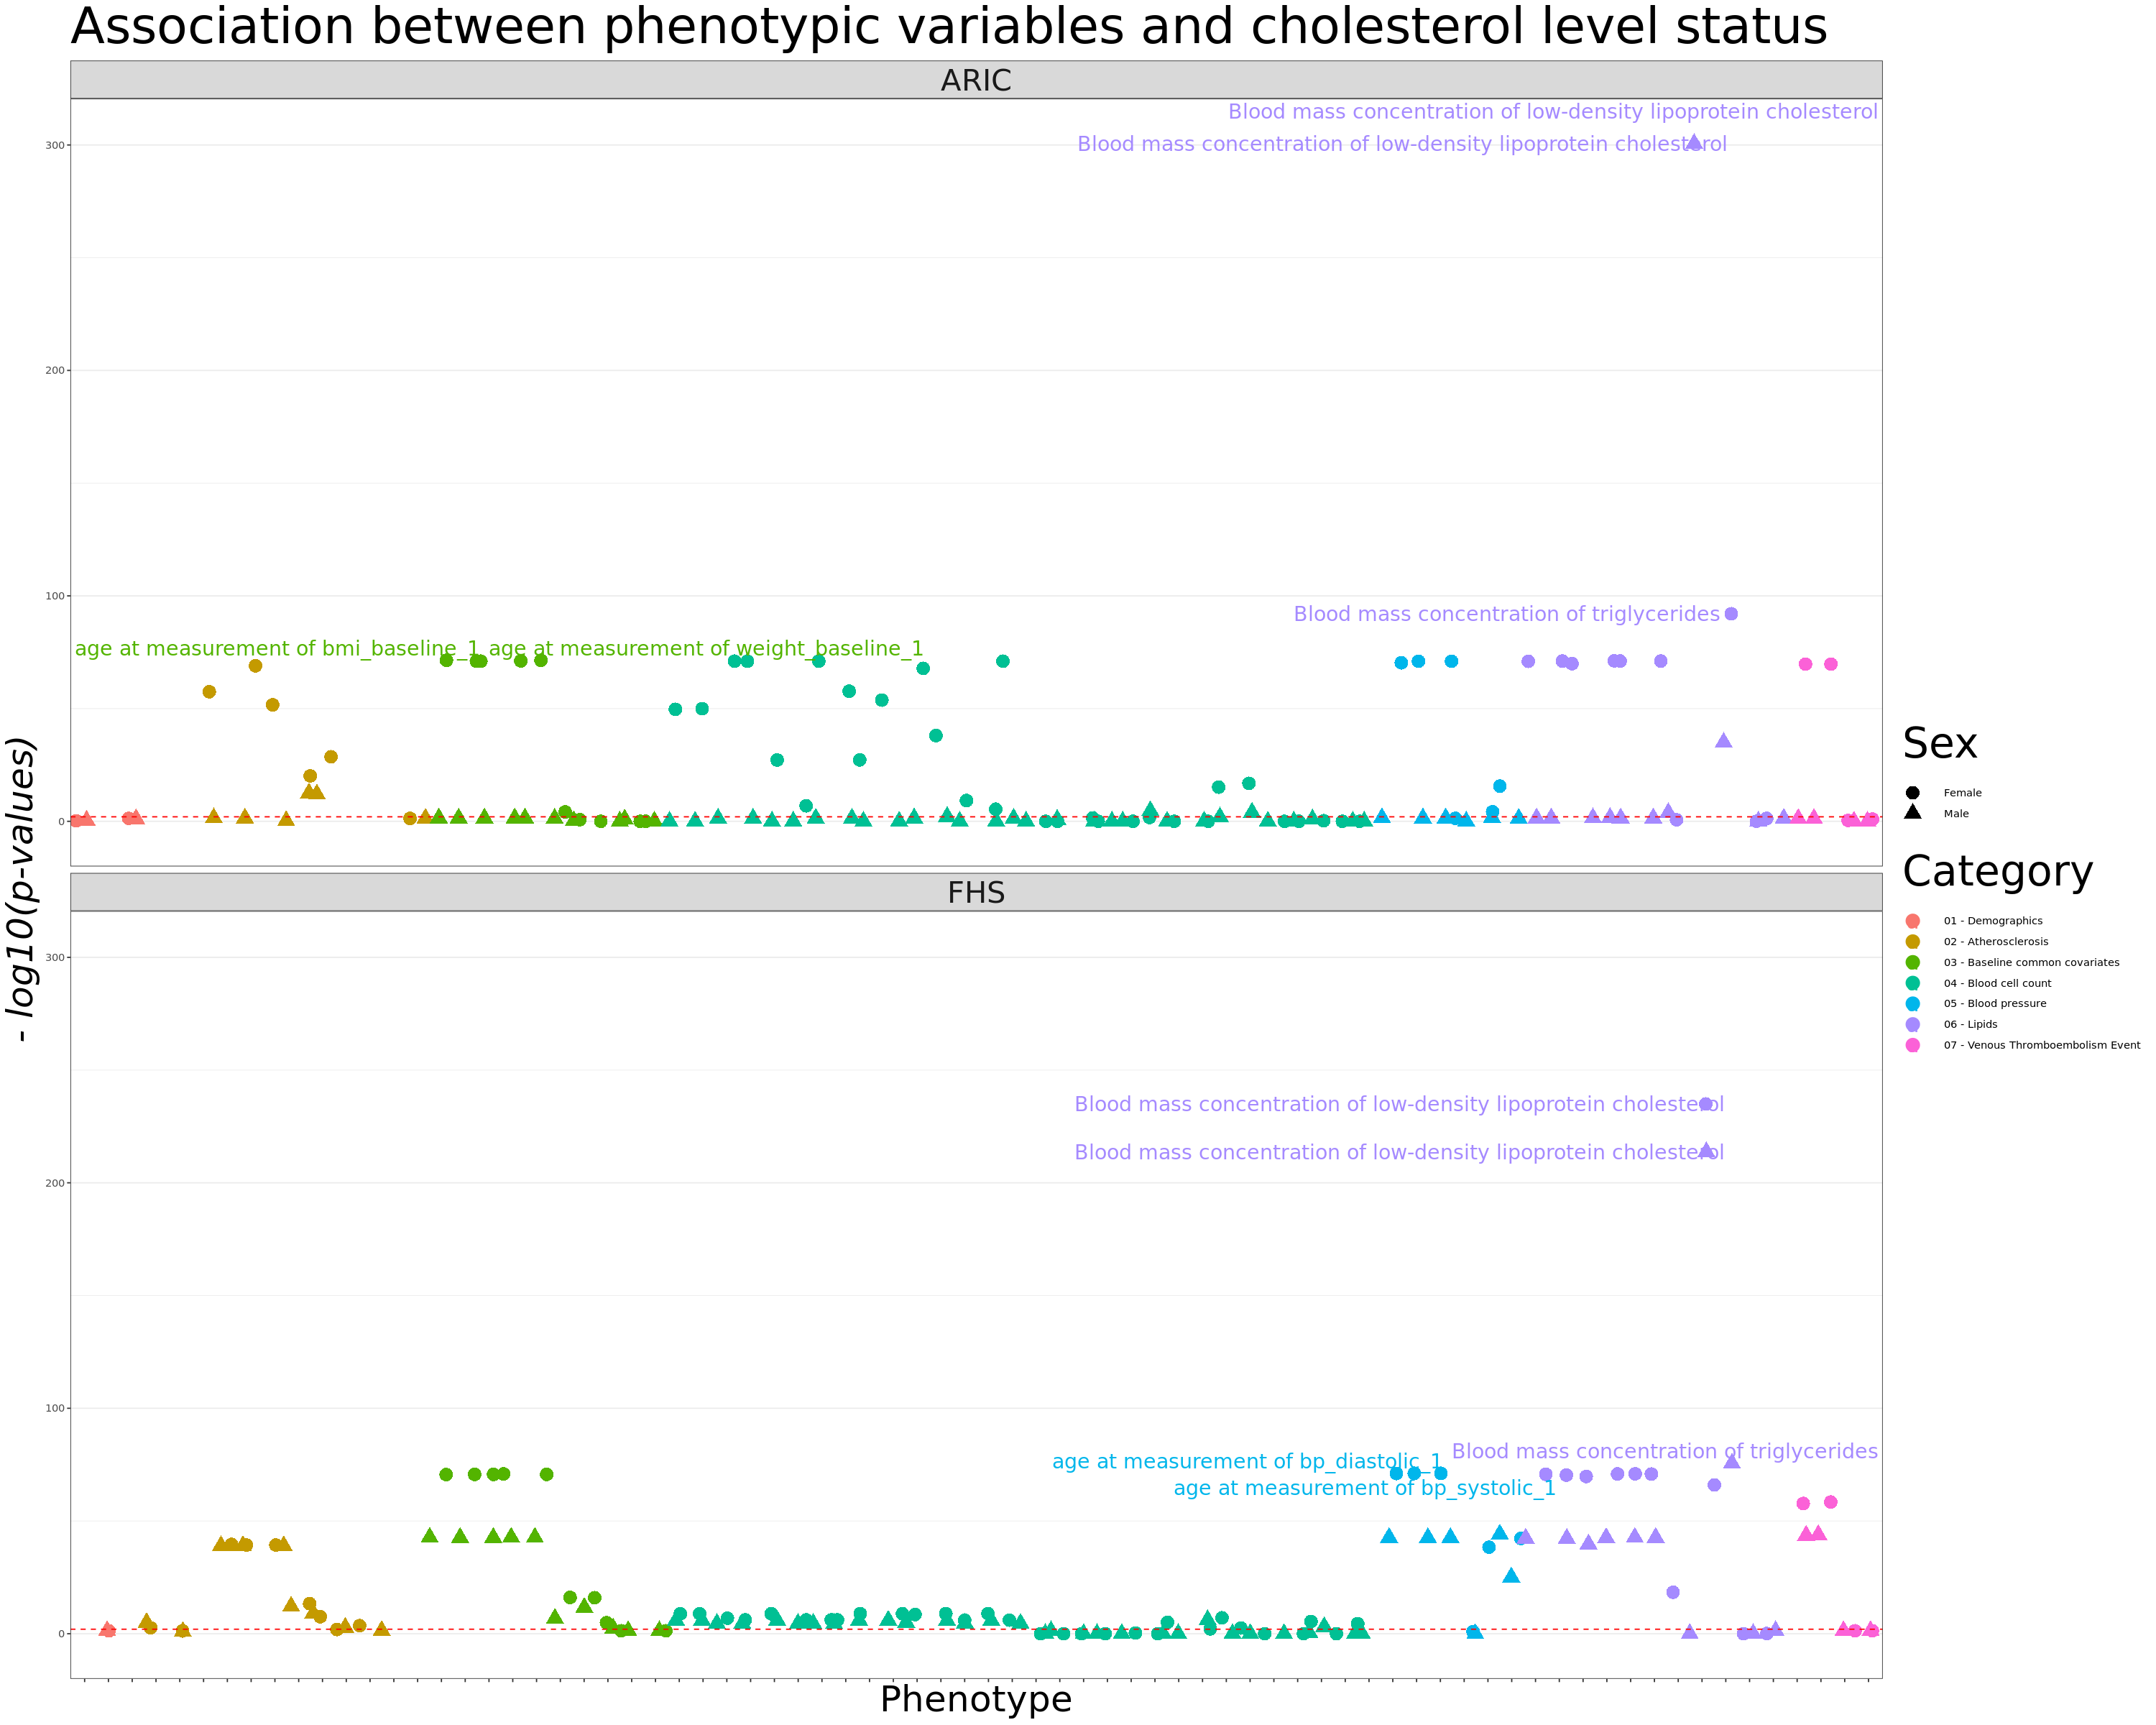

In [72]:
# Manatthan plot using geom_jitter --> more suitable when number of point per category is enough
ggplot(data=plot_df, aes(x=concept_code, y=log_adj_pvalues, 
                         shape=sex, color=category, label=graph_labels)) +
geom_jitter(alpha=1, 
           width=0.5,
           size=5) +
geom_hline(yintercept=adjusted_alpha, linetype="dashed", color = 'red') +
scale_y_continuous(expand = c(0, 20) ) +
geom_text_repel(size=6)+
labs(title="Association between phenotypic variables and cholesterol level status",
    x="Phenotype",
    y="- log10(p-values)",
    colour="Category",
    shape="Sex") +
facet_wrap(facets = vars(study), nrow = 2) +
my_theme


In [91]:
# View top 5 p-values for each study/sex combination
print("FHS Females:")
arrange(fhs_female_df, pval)[1:5,] %>% select(simplified_varname, pval, sex, study)
print("FHS Males:")
arrange(fhs_male_df, pval)[1:5,] %>% select(simplified_varname, pval, sex, study)
print("ARIC Females:")
arrange(aric_female_df, pval)[1:5,] %>% select(simplified_varname, pval, sex, study)
print("ARIC Males:")
arrange(aric_male_df, pval)[1:5,] %>% select(simplified_varname, pval, sex, stud

ERROR: Error in parse(text = x, srcfile = src): <text>:10:0: unexpected end of input
8: print("ARIC Males:")
9: arrange(aric_male_df, pval)[1:5,] %>% select(simplified_varname, pval, sex, stud
  ^
